In [27]:
import os
from utils.core.config import initialize_daanish, load_project_config
from utils.data_io import load_data
from utils.core.feature_manager import FeatureManager
from utils.eda.descriptive import DescriptiveAnalysis
from utils.viz.display import DisplayUtils
from utils.core.save_manager import SaveUtils
from utils.core.format_utils import FormatUtils
from utils.eda.statistical import StatisticalAnalysis
from utils.eda.visualisation import Visualisation
from utils.eda.correlation import CorrelationAnalyzer
import pandas as pd

#### Step 1: Project Initialization and Data Loading 
In this step, we:
- Initialize the Daanish core setup
- Access global and project-specific configuration values
- Construct input and output paths based on project settings
- Load the main dataset for modeling
- Load the list of model features along with their attributes

- Initialize the Daanish core setup

In [28]:
global_config = initialize_daanish()


Daanish core setup complete.


- Access global and project-specific configuration values

In [29]:

project_root = os.getcwd()
project_config = load_project_config(project_root)

input_data_folder = project_config.get('paths', 'input_data_folder')
output_data_folder = project_config.get('paths', 'output_data_folder')
main_dataset = project_config.get('input_files', 'main_dataset')
model_features = project_config.get('input_files', 'features_attributes')
source_type = project_config.get('datasource_type', 'source_type')
main_dataset_query = project_config.get('db_queries', 'main_dataset_query')
model_features_query = project_config.get('db_queries', 'model_features_query')

INFO:utils.core.config:Loading project configuration from c:\Data Science Projects\Daanish\projects\probability_of_default\project_config.ini
INFO:utils.core.config:Project configuration loaded successfully


- Construct input and output paths based on project settings

In [30]:

input_path = os.path.join(project_root, input_data_folder)
output_path = os.path.join(project_root, output_data_folder)

- Load the main dataset for modeling

In [31]:
main_df = load_data(
    source_type=source_type,
    input_path=os.path.join(input_path, main_dataset),
    query=main_dataset_query,
    global_config=global_config
)

- Load the list of model features along with their attributes

In [32]:
feature_manager = FeatureManager(
    source_type=source_type,
    input_path=os.path.join(input_path, model_features),
    global_config=global_config,
    query=model_features_query
)

nominal_features = feature_manager.get_nominal_features()
ordinal_features = feature_manager.get_ordinal_features()
numerical_features = feature_manager.get_numerical_features()
target_variable = feature_manager.get_target_variable()
all_features = feature_manager.get_all_features()
missing_value_strategies = feature_manager.get_missing_value_strategies()
missing_fill_values = feature_manager.get_missing_fill_values()
display_names = feature_manager.get_display_names()

# print("Nominal Features:", nominal_features)
# print("Ordinal Features:", ordinal_features)
# print("Numerical Features:", numerical_features)
# print("Target Variable:", target_variable)
# print("All Features:", all_features)
# print("Missing Value Strategies:", missing_value_strategies)
# print("Missing Fill Values:", missing_fill_values)
# print("Display Names:", display_names)

#### Step 2: Preliminary Exploratory Data Analysis (EDA)

In this step, we explore the raw dataset to understand its structure, identify potential issues (e.g., missing values, outliers, inconsistent types), and gain initial insights into data distributions. This provides the foundation for informed preprocessing and feature engineering decisions later.

In [33]:
# initializing the `DescriptiveAnalysis` class with our main dataset
eda_desc = DescriptiveAnalysis(main_df)

- 2.1 data sample

In [34]:
sample_data = eda_desc.get_data_samples(5)
DisplayUtils.show_dataframe_notebook(sample_data)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
4570,22,99996,RENT,1.000000,EDUCATION,A,10000,9.320000,0,0.100000,N,4
26351,33,100000,MORTGAGE,12.000000,VENTURE,B,8000,11.860000,0,0.080000,N,7
31609,43,112000,MORTGAGE,14.000000,PERSONAL,D,25000,14.960000,0,0.220000,Y,15
24793,29,75996,OWN,3.000000,VENTURE,B,8000,10.740000,0,0.110000,N,10
11320,26,67000,MORTGAGE,2.000000,DEBTCONSOLIDATION,D,6500,14.110000,1,0.100000,Y,2


- 2.2 dataset summary

In [35]:
dataset_summary = eda_desc.get_dataset_summary()
DisplayUtils.show_summary_console(dataset_summary)


=== Dataset Summary ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Columns: 12 entries, person_age to cb_person_cred_hist_length
dtypes: float64(3), int64(5), object(4)

Duplicate Count: 165

Missing Values:
Feature                       Count
--------------------------  -------
person_age                        0
person_income                     0
person_home_ownership             0
person_emp_length               895
loan_intent                       0
loan_grade                        0
loan_amnt                         0
loan_int_rate                  3116
loan_status                       0
loan_percent_income               0
cb_person_default_on_file         0
cb_person_cred_hist_length        0

Missing Percentages:
Feature                     Percentage
--------------------------  ------------
person_age                  0.00%
person_income               0.00%
person_home_ownership       0.00%
person_emp_length           2.75%
loan_intent     

- 2.3 Summary of Feature(s) 

In [36]:
# single_feature_summary = eda_desc.get_feature_summary("loan_amnt")
All_features_summary = eda_desc.get_all_feature_summaries()

- Display Summary

In [37]:
# DisplayUtils.print_feature_summary("loan_amnt", single_feature_summary)
DisplayUtils.print_high_level_summary(All_features_summary)


=== High-Level Feature Summary ===
+---------------------+------------+---------------+-----------------------+-------------------+-------------+------------+--------------+---------------+-------------+---------------------+---------------------------+----------------------------+
|      Statistic      | person_age | person_income | person_home_ownership | person_emp_length | loan_intent | loan_grade |  loan_amnt   | loan_int_rate | loan_status | loan_percent_income | cb_person_default_on_file | cb_person_cred_hist_length |
+---------------------+------------+---------------+-----------------------+-------------------+-------------+------------+--------------+---------------+-------------+---------------------+---------------------------+----------------------------+
|        count        |  32581.00  |   32581.00    |          N/A          |     31686.00      |     N/A     |    N/A     |   32581.00   |   29465.00    |  32581.00   |      32581.00       |            N/A            |  

- Save High Level Descriptive Analysis Summary to CSV and Excel

This cell formats the high-level feature summaries into a structured DataFrame and saves it as a CSV or Excel file. The formatting is handled by `FormatUtils`, which extracts selected statistics for each feature, and the output is saved using `SaveUtils`.

In [38]:
# initializing the `SaveUtils` class
save_utils = SaveUtils()

In [39]:
# Format the summary
df_summary = FormatUtils.high_level_summary_to_dataframe(All_features_summary)

# Save as a CSV file
# save_utils.save_dataframe_to_csv(df_summary, os.path.join(output_path, "descriptive_summary.csv"), overwrite=True)

# Save as an Excel file
# save_utils.save_dataframe_to_excel(df_summary, os.path.join(output_path, "descriptive_summary.xlsx"), sheet_name='Descriptive Summary')

- Save Detailed Descriptive Analysis Summary to JSON
This cell saves the detailed descriptive analysis summary as a JSON file.  
It is intended for use by applications or services that need to consume and display the analysis results.

In [40]:
# Save as JSON file
# save_utils.save_json(All_features_summary, os.path.join(output_path, "descriptive_summary.json"), overwrite=True)

### 🔍 2.4 Find the Best-Fit Probability Distribution for Selected Features
This cell identifies the best-fit probability distribution for each feature in the given list.
- **Method**: Defines the criterion for selecting the best fit. Options are:
  - `'sumsquare_error'` *(default)*
  - `'aic'`
  - `'bic'`

- **common_distributions (bool)**:  
  - If `True`, only fits a curated list of commonly used distributions:  
    `'norm'`, `'expon'`, `'lognorm'`, `'gamma'`, `'beta'`, `'weibull_min'`, `'chi2'`, `'pareto'`, `'uniform'`, `'t'`, `'gumbel_r'`, `'burr'`, `'invgauss'`, `'triang'`, `'laplace'`, `'logistic'`, `'genextreme'`, `'skewnorm'`, `'genpareto'`, `'burr12'`, `'fatiguelife'`, `'geninvgauss'`, `'halfnorm'`, `'exponpow'`

  - If `False`, fits from an extended list of over 100 SciPy continuous distributions.

In [41]:
# initializing the `StatisticalAnalysis` class
eda_stat = StatisticalAnalysis(main_df)

# Finding the best-fit probability distribution
# distribution_results = eda_stat.fit_best_distribution(numerical_features, method='sumsquare_error', common_distributions=True, timeout=60)
# distribution_results = eda_stat.fit_best_distribution(['person_age', 'loan_amnt'], method='sumsquare_error', common_distributions=True, timeout=60)

- Plotting the best-fit distributions for a given feature(s) set

In [42]:
# initializing the `Visualisation` class
viz = Visualisation(main_df, display_names)

# Plotting best-fit distributions
# viz.plot_distributions(fitted_distributions = distribution_results,variables=numerical_features)
# viz.plot_distributions(fitted_distributions = distribution_results,variables=['person_age', 'loan_amnt'])

- 📊Plot Histograms for Selected Features
This cell visualizes the distribution of selected features using histograms.

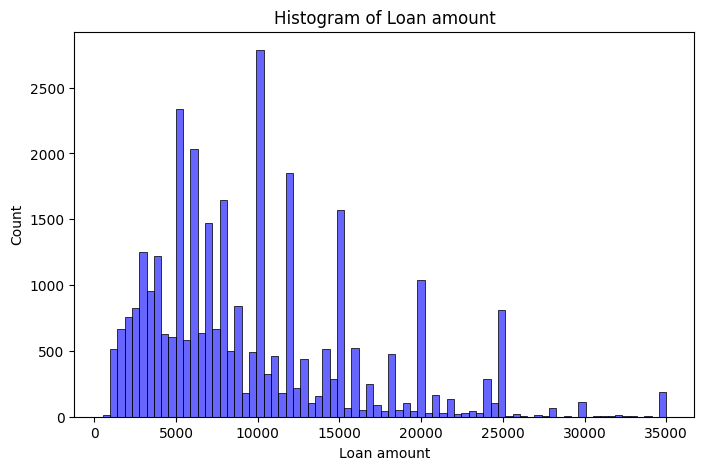

In [43]:
    # viz.plot_histogram(variables=numerical_features, orientation="vertical")
viz.plot_histogram(variables=['loan_amnt'], orientation="vertical")

    # viz.plot_histogram(variables=nominal_features, orientation="horizontal")
    # viz.plot_histogram(variables=['loan_intent'], orientation="horizontal")


- 🔵 Scatter Plots for Relationship Analysis
This cell provides visualizations to explore relationships between two numerical variables, with optional grouping and trendlines.

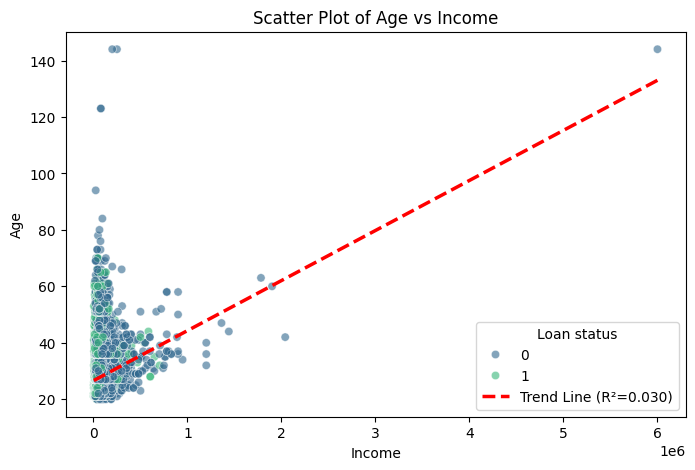

In [44]:
# Scatter plot with color based on `loan_grade`
viz.plot_scatter(x_var="person_income", y_var="person_age", hue_var="loan_status", trendline=True)
# viz.plot_scatter(x_var="person_income", y_var="loan_amnt", hue_var="loan_status", trendline=True)
# viz.plot_scatter(x_var="loan_int_rate", y_var="loan_amnt", hue_var="loan_status", trendline=True)
# viz.plot_scatter(x_var="loan_int_rate", y_var="person_income", hue_var="loan_status", trendline=True)


# Scatter plot with trendline
# viz.plot_scatter(x_var="person_age", y_var="person_income", trendline=True)

- 🟩 Box Plots for Distribution Comparison

This cell uses box plots to compare the distribution of a numerical variable across categories of another feature.

<Figure size 800x600 with 0 Axes>

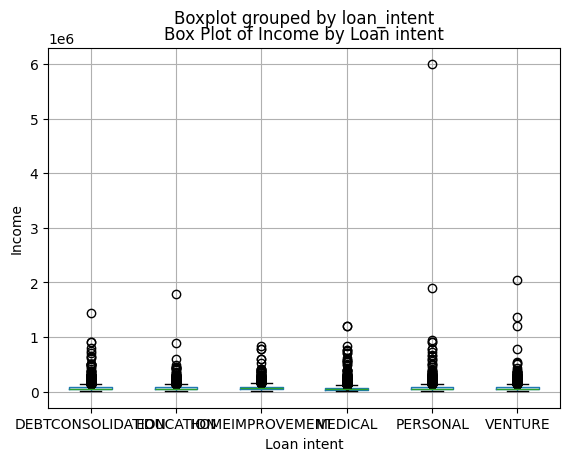

<Figure size 800x600 with 0 Axes>

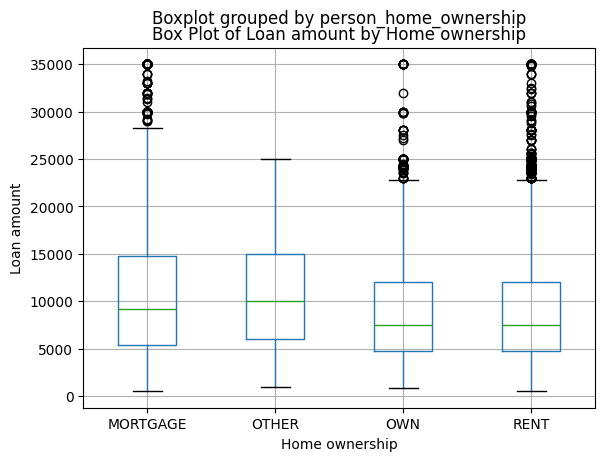

<Figure size 800x600 with 0 Axes>

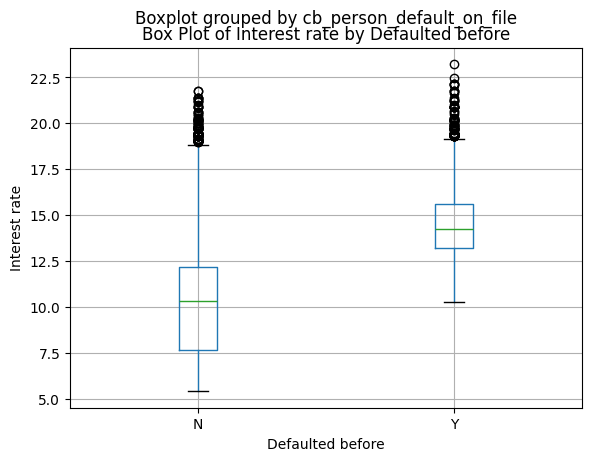

<Figure size 800x600 with 0 Axes>

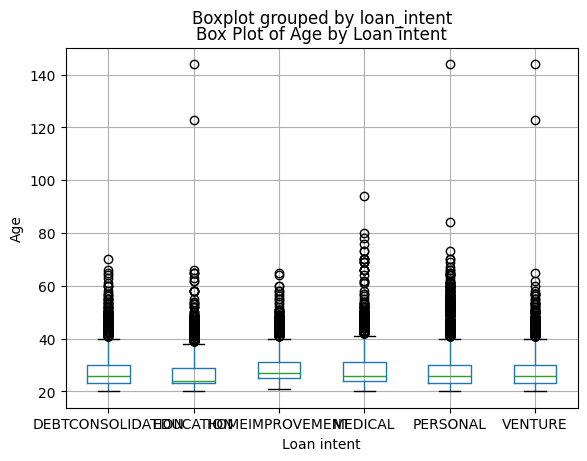

In [45]:
viz.plot_boxplot(column='person_income', by='loan_intent')
viz.plot_boxplot(column='loan_amnt', by='person_home_ownership')
viz.plot_boxplot(column='loan_int_rate', by='cb_person_default_on_file')
viz.plot_boxplot(column='person_age', by='loan_intent')


- 📊 Crosstab Analysis
This section generates cross-tabulation (contingency) tables to explore the relationship between categorical variables.

In [46]:
# For two variables
crosstab_result_1 = eda_stat.crosstab("loan_status", "person_home_ownership", normalize="index")
crosstab_result_2 = eda_stat.crosstab("loan_status", "loan_intent", normalize="index")
crosstab_result_3 = eda_stat.crosstab("loan_status", "cb_person_default_on_file", normalize="index")

# For three variables
crosstab_result_4 = eda_stat.crosstab_three_way("loan_status", "cb_person_default_on_file", "person_home_ownership")


In [47]:
# Display
# crosstab_result_1
# crosstab_result_2
# crosstab_result_3
crosstab_result_4

#### 🔗 2.5 Examine Variable Correlations

This section calculates and displays correlations between different types of variables in the `main_df`.

- **`num_method` (str)**: Defines the method for calculating correlation between numerical variables. Allowed values are:
    - `'pearson'` *(default)*: Standard Pearson linear correlation coefficient.
    - `'spearman'`: Spearman's rank correlation coefficient (for monotonic relationships).
    - `'kendall'`: Kendall's tau correlation coefficient (for ordinal or non-normally distributed data).

- **`cat_method` (str)**: Defines the method for calculating association between categorical variables. Allowed values are:
    - `'cramers_v'` *(default)*: Cramer's V (measures association between nominal categorical variables).
    - `'mutual_info'`: Mutual Information (measures the statistical dependence between two random variables).

- **`cat_num_method` (str)**: Defines the method for calculating association between categorical and numerical variables. Allowed values are:
    - `'correlation_ratio'` *(default)*: Correlation Ratio (Eta squared, measures variance explained).
    - `'f_test'`: F-statistic from ANOVA (assesses the difference in means across categories).
    - `'mutual_info'`: Mutual Information (measures the statistical dependence).

- **`threshold` (float, optional)**: Specifies the threshold for highlighting high correlations. Only pairs with an absolute correlation value greater than or equal to this threshold will be included in the `"high_correlation"` part of the results. Defaults to `0.7`.

The `get_unified_correlation_table` method of the `CorrelationAnalyzer` returns a DataFrame (`unified_corr`) containing all pairwise correlations calculated based on the specified methods. 

In [ ]:
analyzer = CorrelationAnalyzer(main_df)
corr_df = analyzer.correlation_matrix(num_method="spearman", cat_method="cramers_v",
                                      cat_num_method="correlation_ratio")

# Save as an Excel file
save_utils.save_dataframe_to_excel(corr_df, os.path.join(output_path, "correlation_matrix.xlsx"))

Excel file saved to c:\Data Science Projects\Daanish\projects\probability_of_default\data/output/correlation_matrix.xlsx successfully.
